# Calculation Part

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [2]:
def load_images(folder):
    images = []
    labels = []
    class_dirs = ['Carambula', 'Lychee', 'Pear']
    for idx, fruit in enumerate(class_dirs):
        fruit_path = os.path.join(folder, fruit)
        for image_name in os.listdir(fruit_path):
            image_path = os.path.join(fruit_path, image_name)
            img = Image.open(image_path).convert('L')
            img = np.array(img).flatten()
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)


def preprocess_data(data_folder, pca_components):
    X_train, y_train = load_images(os.path.join(data_folder, 'Data_train'))
    X_test, y_test = load_images(os.path.join(data_folder, 'Data_test'))

    # Normalize the data
    X_train = X_train / 255
    X_test = X_test / 255

    # Perform PCA
    pca = PCA(n_components=pca_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Add bias term
    X_train_pca = np.hstack((X_train_pca, np.ones((X_train_pca.shape[0], 1))))
    X_test_pca = np.hstack((X_test_pca, np.ones((X_test_pca.shape[0], 1))))

    return X_train_pca, X_test_pca, y_train, y_test


def one_hot_encode(y, num_classes):
    y_one_hot = np.zeros((len(y), num_classes))
    unique_labels = np.unique(y)
    for i, label in enumerate(unique_labels):
        y_one_hot[y == label, i] = 1
    return y_one_hot


def sigmoid(x):
    x = np.clip(x, -500, 500)  # Limit the input values to avoid overflow
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return x * (1 - x)


class ThreeLayerNN:
    def __init__(self, input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes):
        self.input_nodes = input_nodes
        self.hidden_nodes_1 = hidden_nodes_1
        self.hidden_nodes_2 = hidden_nodes_2
        self.output_nodes = output_nodes
        self.loss_arr = []

        self.weights1 = np.random.randn(input_nodes, hidden_nodes_1)
        self.weights2 = np.random.randn(hidden_nodes_1, hidden_nodes_2)
        self.weights3 = np.random.randn(hidden_nodes_2, output_nodes)
        self.bias1 = np.random.randn(1, self.hidden_nodes_1)
        self.bias2 = np.random.randn(1, self.hidden_nodes_2)
        self.bias3 = np.random.randn(1, self.output_nodes)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.layer1 = sigmoid(np.dot(X, self.weights1) + self.bias1)
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2) + self.bias2)
        output = self.softmax(np.dot(self.layer2, self.weights3) + self.bias3)
        return output

    def backprop(self, X, y, output, learning_rate=0.001):
        self.layer3_error = y - output
        self.layer3_delta = self.layer3_error * sigmoid_derivative(output)

        self.layer2_error = np.dot(self.layer3_delta, self.weights3.T)
        self.layer2_delta = self.layer2_error * sigmoid_derivative(self.layer2)

        self.layer1_error = np.dot(self.layer2_delta, self.weights2.T)
        self.layer1_delta = self.layer1_error * sigmoid_derivative(self.layer1)

        self.weights1 += learning_rate * np.dot(X.T, self.layer1_delta)
        self.weights2 += learning_rate * \
            np.dot(self.layer1.T, self.layer2_delta)
        self.weights3 += learning_rate * \
            np.dot(self.layer2.T, self.layer3_delta)

    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = len(y_true)
        y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
        loss = -np.sum(y_true * np.log(y_pred_clipped)) / n_samples
        return loss

    def train(self, X, y, epochs=1000, learning_rate=0.001, batch_size = 16):
        for epoch in range(epochs):
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            for start_idx in range(0, len(X), batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                X_batch, y_batch = X[batch_indices], y[batch_indices]
            
                output_batch = self.forward(X_batch)
                
                self.backprop(X_batch, y_batch, output_batch, learning_rate)
                
            loss = self.cross_entropy_loss(y_batch, output_batch)
            self.loss_arr.append(loss)
            if epoch % 100 == 0:
                    print(f'loss: {loss}')

    def predict(self, X):
        output = self.forward(X)
        predictions = np.argmax(output, axis=1)
        return predictions
    
    def plot_loss(self):
        plt.plot(self.loss_arr, 'r-', label='training loss')
        plt.xlabel('Epoch(s)')
        plt.ylabel('Cross-entropy loss')
        plt.legend()
        plt.show()

    def plot_decision_regions(self, X, y, label):
        # Create a grid of points
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                            np.arange(y_min, y_max, 0.1))

        # Flatten the grid points and add a column of ones for the bias term
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_points = np.hstack((grid_points, np.ones((grid_points.shape[0], 1))))

        # Pass the grid points through the neural network
        output = self.forward(grid_points)
        predictions = np.argmax(output, axis=1)

        # Reshape the predictions to match the grid shape
        predictions = predictions.reshape(xx.shape)

        # Plot the decision regions
        plt.contourf(xx, yy, predictions, alpha=0.3)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=80)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(label)
        plt.show() 


def custom_train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)

    data_size = len(X)
    indices = np.arange(data_size)
    np.random.shuffle(indices)

    split_index = int(data_size * (1 - test_size))
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test


def accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

In [3]:
# Load and preprocess your dataset (PCA and train-validation split)
data_folder = 'Data'
pca_components = 2

X_train, X_test, y_train, y_test = preprocess_data(data_folder, pca_components)
X_train, X_val, y_train, y_val = custom_train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

num_classes = 3
y_train_one_hot = one_hot_encode(y_train, num_classes)
y_val_one_hot = one_hot_encode(y_val, num_classes)

# Define neural network parameters
input_nodes = 3  # Two principal components plus bias
hidden_nodes_1 = 256
hidden_nodes_2 = 64
output_nodes = 3

# Create and train the neural network
nn = ThreeLayerNN(input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes)
nn.train(X_train, y_train_one_hot, epochs=1000)

# Evaluate the model's performance on the validation data
y_val_pred = nn.predict(X_val)
val_accuracy = accuracy(y_val, y_val_pred)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

loss: 2.752362287262251
loss: 0.24142248700803778
loss: 0.31011720338809035
loss: 0.12113487267795428
loss: 0.7079337811933182
loss: 0.09360982876483248
loss: 0.2643317277150223
loss: 0.09232131387413561
loss: 0.11362580240714934
loss: 0.07493977365299653
Validation accuracy: 94.90%


# Accuracy Part

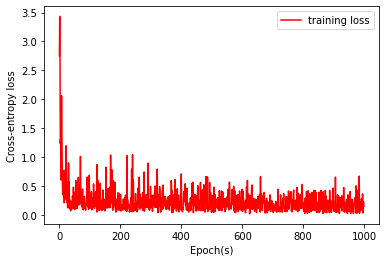

In [4]:
nn.plot_loss()

# Decision Part

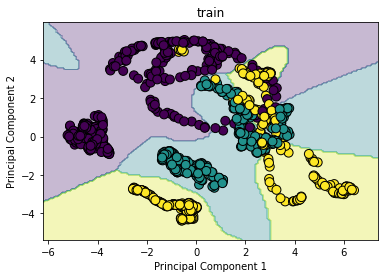

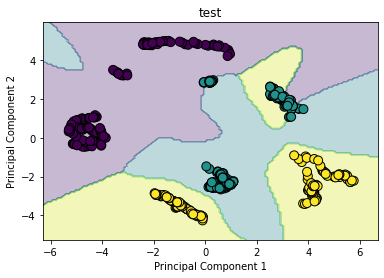

In [5]:
nn.plot_decision_regions(X_train, y_train, label='train')
nn.plot_decision_regions(X_test, y_test, label='test')

# Batch Size

--Train batch_sizes = 8 start--
loss: 6.634815695528504
loss: 0.6290541696448495
loss: 0.08150981605767646
loss: 0.10820134767967299
loss: 0.04719798065288744
--Train batch_sizes = 16 start--
loss: 2.9573455687538424
loss: 0.18947253221624544
loss: 0.16829330956844185
loss: 0.3620007547028606
loss: 0.22115881447036562
--Train batch_sizes = 32 start--
loss: 5.989259685959177
loss: 0.28680209193686457
loss: 0.20565238828884536
loss: 0.10373863156060227
loss: 0.3027801938070663
--Train batch_sizes = 64 start--
loss: 3.743945934769999
loss: 0.1580400474150073
loss: 0.24559556806543617
loss: 0.11335032592065426
loss: 0.13872409212410927


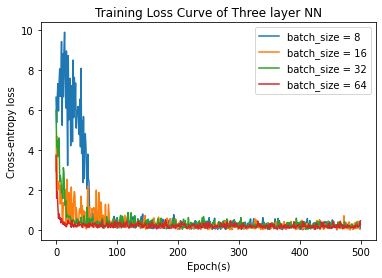

In [6]:
batch_sizes = [2**i for i in range(3, 7)]
for batch_size in batch_sizes:
    print(f'--Train batch_sizes = {batch_size} start--')
    nn = ThreeLayerNN(input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes)
    nn.train(X_train, y_train_one_hot, epochs=500, batch_size=batch_size)
    plt.plot(nn.loss_arr, label=f'batch_size = {batch_size}')
plt.title(f'Training Loss Curve of Three layer NN')
plt.xlabel('Epoch(s)')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# Hidden Layer Size

--Train hidden_1_size = 16
--Train hidden_2_size = 16 start--
loss: 2.506011930876136
loss: 0.5765726853193811
loss: 0.6163682015514895
loss: 0.3157887992245284
loss: 0.33018231170850304
--Train hidden_2_size = 32 start--
loss: 2.6704603534212636
loss: 0.4947687507584164
loss: 0.3034856501903547
loss: 0.35297399311633265
loss: 0.4307026062222392
--Train hidden_2_size = 64 start--
loss: 1.3051965388461388
loss: 0.21469250478725976
loss: 0.28574396114940753
loss: 0.18130344567980985
loss: 0.14541349945072332
--Train hidden_2_size = 128 start--
loss: 6.300346873351342
loss: 0.39189856971958403
loss: 0.4149869045170735
loss: 0.3085971509481904
loss: 0.43120820809090765


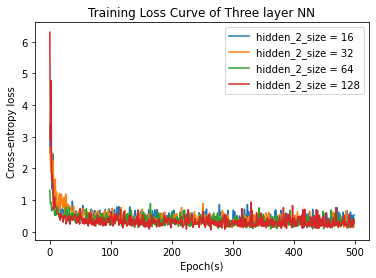

--Train hidden_1_size = 32
--Train hidden_2_size = 16 start--
loss: 1.1361412410349863
loss: 0.2785312317564037
loss: 0.2138076004000317
loss: 0.2680508747403825
loss: 0.4547435823528032
--Train hidden_2_size = 32 start--
loss: 1.3704739125720018
loss: 0.32659843013177997
loss: 0.12065448622816817
loss: 0.21846882546056431
loss: 0.1344517882165525
--Train hidden_2_size = 64 start--
loss: 12.587193020601864
loss: 16.33227074337398
loss: 8.418658045772881
loss: 11.306919015561318
loss: 10.761364778311295
--Train hidden_2_size = 128 start--
loss: 6.053079526655189
loss: 0.7604327245240676
loss: 0.45052719615231235
loss: 0.1346823661104395
loss: 0.6738119934178258


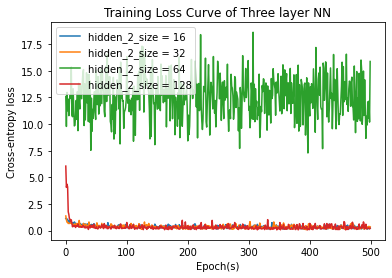

--Train hidden_1_size = 64
--Train hidden_2_size = 16 start--
loss: 2.2770241675221228
loss: 0.4289020212074412
loss: 0.3355752946828094
loss: 0.19772828767684947
loss: 0.3898652360231727
--Train hidden_2_size = 32 start--
loss: 2.0788932673337217
loss: 0.25260426834874
loss: 0.37255653609853856
loss: 0.3039967858874453
loss: 0.7180194682704983
--Train hidden_2_size = 64 start--
loss: 5.661787373197767
loss: 0.2736681921411617
loss: 0.1318502476784477
loss: 0.2683628156191837
loss: 0.16169103690885014
--Train hidden_2_size = 128 start--
loss: 15.958043044866846
loss: 14.424522064044131
loss: 19.175432635236607
loss: 13.799182383592994
loss: 14.866169600673926


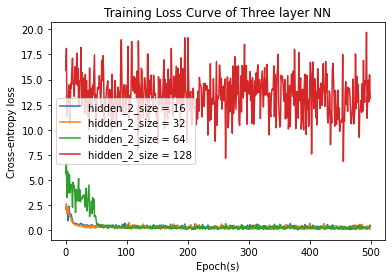

--Train hidden_1_size = 128
--Train hidden_2_size = 16 start--
loss: 1.302262426333253
loss: 0.4307708680974968
loss: 0.26066153566349887
loss: 0.2857691429799733
loss: 0.167790752713614
--Train hidden_2_size = 32 start--
loss: 2.8535349204268843
loss: 0.5428358000253187
loss: 0.2865045349419789
loss: 0.2645739108990329
loss: 0.2838082661978984
--Train hidden_2_size = 64 start--
loss: 3.845763321585242
loss: 0.24820828604640519
loss: 0.5133297629124092
loss: 0.3399163727549124
loss: 0.1406132062319194
--Train hidden_2_size = 128 start--
loss: 5.148987014444428
loss: 0.19368744623288534
loss: 0.19994041946518357
loss: 0.47453501206570764
loss: 0.2909588861882368


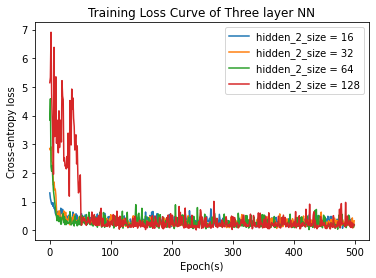

In [7]:
hidden_1_sizes = [2**i for i in range(4, 8)]
hidden_2_sizes = [2**i for i in range(4, 8)]
for hidden_1_size in hidden_1_sizes:
    print(f'--Train hidden_1_size = {hidden_1_size}')
    for hidden_2_size in hidden_2_sizes:
        print(f'--Train hidden_2_size = {hidden_2_size} start--')
        nn = ThreeLayerNN(input_nodes, hidden_1_size, hidden_2_size, output_nodes)
        nn.train(X_train, y_train_one_hot, epochs=500, batch_size=32)
        plt.plot(nn.loss_arr, label=f'hidden_2_size = {hidden_2_size}')
    plt.title(f'Training Loss Curve of Three layer NN')
    plt.xlabel('Epoch(s)')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()

# Tuning part

In [8]:
# Load and preprocess your dataset (PCA and train-validation split)
data_folder = 'Data'
pca_components = 2

X_train, X_test, y_train, y_test = preprocess_data(data_folder, pca_components)
X_train, X_val, y_train, y_val = custom_train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

num_classes = 3
y_train_one_hot = one_hot_encode(y_train, num_classes)
y_val_one_hot = one_hot_encode(y_val, num_classes)

# Define neural network parameters
input_nodes = 3  # Two principal components plus bias
hidden_nodes_1 = 1024
hidden_nodes_2 = 512
output_nodes = 3

# Create and train the neural network
nn = ThreeLayerNN(input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes)
nn.train(X_train, y_train_one_hot, epochs=2000)

# Evaluate the model's performance on the validation data
y_val_pred = nn.predict(X_val)
val_accuracy = accuracy(y_val, y_val_pred)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

loss: 5.961705204767846
loss: 0.2059253021637017
loss: 0.13570473470359457
loss: 0.028430982050795337
loss: 0.029360911995640726
loss: 0.19998078453337742
loss: 0.05900410353074784
loss: 0.11764240548134207
loss: 0.0281512665565232
loss: 0.1878648977358342
loss: 0.011628907611138647
loss: 0.007470868792711195
loss: 0.04432064811722147
loss: 0.1386664464090963
loss: 0.07112013114140345
loss: 0.01309617751122954
loss: 0.09131402634013738
loss: 0.06899125323779579
loss: 0.07091857350545668
loss: 0.012318418073627102
Validation accuracy: 95.92%
